In [1]:
#### import 
import logging
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer
from sklearn.neighbors import KNeighborsClassifier
from umap import UMAP
import matplotlib.pyplot as plt
from reval.best_nclust_cv import FindBestClustCV

In [2]:
main_path = '/Users/vmandelli/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition'
data_path = os.path.join(main_path,"data","tidy","nda")
results_path = os.path.join(main_path,"results")
plot_path = os.path.join(main_path,"plot")

In [3]:
# load train set
file = 'NDA_tr_format_corrected.csv'
X_tr_ = pd.read_csv(os.path.join(data_path,file),
                        header=0,
                        #skiprows=[1],
                        low_memory=False,
                        index_col='subjectkey')
# load test set
file = 'NDA_ts_format_corrected.csv'
X_ts_ = pd.read_csv(os.path.join(data_path,file),
                        header=0,
                        #skiprows=[1],
                        low_memory=False,
                        index_col='subjectkey')
#keep track of the original
TR_original = X_tr_
TS_original = X_ts_

In [4]:
TR_original

,Unnamed: 0,ageyrs_round,interview_period,collection_id,interview_age,edition,original_communicationdomain_totalb,original_livingskillsdomain_totalb,original_socializationdomain_totalb,original_motorskillsdomain_totalb,original_composite_totalb,sex,countna,format,TR_TS,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb
subjectkey,,,,,,,,,,,,,,,,,,,,
NDARYH920PMG,1,5,P1,1865,63,2,79.0,100,77.0,94.0,85.0,M,0,survey,tr,83.114274,101.097414,80.081418,96.312881,87.483174
NDAREZ550UCM,2,3,P1,1,40,2,89.0,83,81.0,94.0,84.0,F,0,survey,tr,93.114274,84.097414,84.081418,96.312881,86.483174
NDARKL624BHL,3,5,P1,1,61,2,83.0,69,65.0,70.0,68.0,M,0,survey,tr,87.114274,70.097414,68.081418,72.312881,70.483174
NDARJA752ZZK,4,1,P1,2026,15,2,80.0,91,98.0,100.0,90.0,M,0,survey,tr,84.114274,92.097414,101.081418,102.312881,92.483174
NDAR_INVMZ8TWKBC,5,6,P1,2064,68,2,61.0,69,83.0,72.0,68.0,M,0,interview,tr,61.000000,69.000000,83.000000,72.000000,68.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVYH008FAE,599,6,P1,1600,70,2,104.0,97,108.0,88.0,99.0,M,0,interview,tr,104.000000,97.000000,108.000000,88.000000,99.000000
NDARZH868ZU9,600,2,P1,1946,18,2,87.0,75,82.0,102.0,84.0,M,0,interview,tr,87.000000,75.000000,82.000000,102.000000,84.000000
NDARWA696YWX,601,4,P1,14,50,2,93.0,89,75.0,111.0,90.0,M,0,survey,tr,97.114274,90.097414,78.081418,113.312881,92.483174


In [5]:
col2use = ['communicationdomain_totalb','livingskillsdomain_totalb',
              'socializationdomain_totalb','motorskillsdomain_totalb']

In [8]:
#define stract vect
strat_vect = X_tr_['sex'] + X_tr_['ageyrs_round'].astype("str")+X_tr_['format']
strat_vect

subjectkey
NDARYH920PMG           M5survey
NDAREZ550UCM           F3survey
NDARKL624BHL           M5survey
NDARJA752ZZK           M1survey
NDAR_INVMZ8TWKBC    M6interview
                       ...     
NDAR_INVYH008FAE    M6interview
NDARZH868ZU9        M2interview
NDARWA696YWX           M4survey
NDARVW054MKJ           M6survey
NDARWX070UF4           M2survey
Length: 603, dtype: object

In [9]:
# preprocessing

# imputation
impute = KNNImputer(n_neighbors=5)

# scaling  
Scaler = StandardScaler()

#umap
Umap = UMAP(n_neighbors=30, min_dist=0.0, n_components=2, random_state=42)

# impute then scale than UMAP
X_tr_prepr = pd.DataFrame(Umap.fit_transform(Scaler.fit_transform(impute.fit_transform(X_tr_[col2use]))), index = X_tr_.index)
X_ts_prepr = pd.DataFrame(Umap.transform(Scaler.transform(impute.transform(X_ts_[col2use]))), index = X_ts_.index)



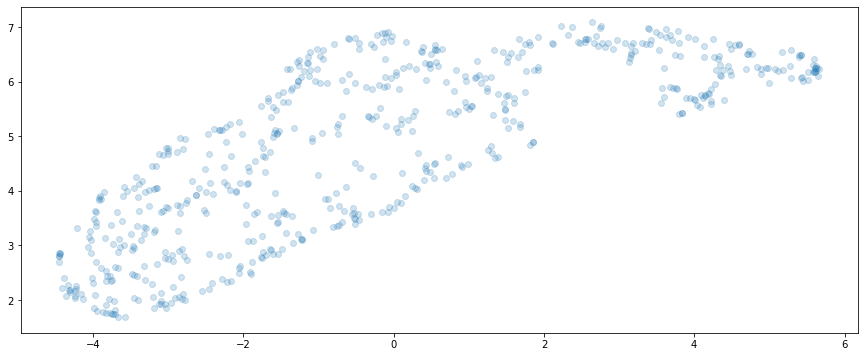

In [10]:
plt.figure(figsize=(15,6))
plt.scatter(X_tr_prepr[[0]], X_tr_prepr[[1]],alpha=0.2)

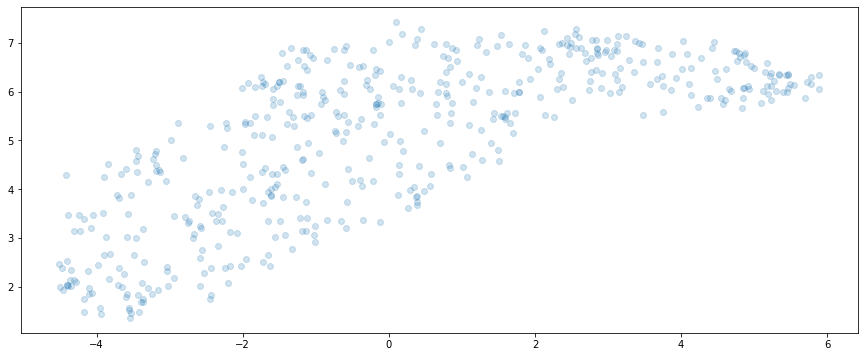

In [11]:
plt.figure(figsize=(15,6))
plt.scatter(X_ts_prepr[[0]], X_ts_prepr[[1]],alpha=0.2)

In [12]:
def Gridsearch(X_tr,strat_vect):

    # GRID SEARCH
    
    # initialize impty saving matrices
    #metric_df = pd.DataFrame()
    metric_dict ={'fold': [],"n_neigh":[],'ncl':[],'stab':[],'err':[]}
    
    
    # define params to test
    # KMEANS
    clust = KMeans(random_state=42)
    vect_hyper = [5,15,30]
    
    
    vect_fold = [2]
    
    # run the grid search
    for f in vect_fold:
        for n in vect_hyper:
            logging.info(f"fold:{f} -- nighbors:{n}")
            clf = KNeighborsClassifier(n_neighbors=n)
            #clf = RandomForestClassifier(n_estimators=n)
            relval = FindBestClustCV(s=clf, c=clust, nfold=f, nclust_range=list(range(2,11,1)), nrand=100)
            metric, ncl = relval.best_nclust(X_tr,iter_cv=100, strat_vect = strat_vect) 
            metric_dict['fold'].append(f)
            metric_dict['n_neigh'].append(n)
            metric_dict['ncl'].append(ncl)
            metric_dict['stab'].append(metric['val'][ncl][0])
            metric_dict['err'].append(metric['val'][ncl][1][1])

    metric_df = pd.DataFrame(metric_dict)

    return metric_df


In [13]:
# run grid search
# define dataset
X_tr = X_tr_prepr.copy()
X_ts = X_ts_prepr.copy()
X_tr_indx = X_tr.index
strat_vect=strat_vect


In [14]:
metric_df_edition_corrected = Gridsearch(X_tr , strat_vect)

10:10:15, INFO fold:2 -- nighbors:5
10:38:12, INFO fold:2 -- nighbors:15
11:09:47, INFO fold:2 -- nighbors:30


In [15]:
mean_stab_err = list(metric_df_edition_corrected[["stab","err"]].apply(np.mean,1))
idx = mean_stab_err.index(min(mean_stab_err))
num_neigh = pd.to_numeric(metric_df_edition_corrected.loc[idx]['n_neigh']).astype(np.int64)

In [16]:
num_neigh

5

In [17]:
metric_df_edition_corrected.to_csv(os.path.join(results_path,'metric_gridsearch_041022.csv'))
metric_df_edition_corrected

,fold,n_neigh,ncl,stab,err
0,2,5,3,0.040694,0.003560
1,2,15,3,0.052133,0.003957
2,2,30,3,0.057583,0.005232


In [18]:
# define dataset
X_tr = X_tr_prepr.copy()
X_ts = X_ts_prepr.copy()
#X_tr_indx = X_tr.index
strat_vect = strat_vect

In [19]:
X_tr

,0,1
subjectkey,,
NDARYH920PMG,-2.832685,2.424239
NDAREZ550UCM,-2.821369,2.932608
NDARKL624BHL,-1.260354,6.392109
NDARJA752ZZK,-3.865186,1.787134
NDAR_INVMZ8TWKBC,-0.087126,5.927867
...,...,...
NDAR_INVYH008FAE,-4.450335,2.801444
NDARZH868ZU9,-1.736975,2.871628
NDARWA696YWX,-2.965081,1.943408


In [20]:
# run reval (only the train)
# classifcation algorhythm
clf = KNeighborsClassifier(n_neighbors= num_neigh)      #KNN  
# cluster algorhythm
clust = KMeans(random_state=42)                #Kmeans



# initialize the class
relval = FindBestClustCV(s=clf, c=clust, nfold=2, nclust_range=list(range(2,11,1)), nrand=100)
    
# train
metric, ncl = relval.best_nclust(X_tr,iter_cv=100, strat_vect = strat_vect)
print(metric)
print(ncl)

out = relval.evaluate(X_tr, X_ts, ncl) # riscrivi NCL qui! il best!

logging.info(f"Training ACC: {out.train_acc}, Test ACC: {out.test_acc}")

12:10:42, INFO Training ACC: 0.9950248756218906, Test ACC: 0.9616161616161616


{'train': {2: (0.005289872610063601, (0.005289872610063601, 0.0004873553274341461)), 3: (0.006699687575630916, (0.006699687575630916, 0.000595746086631139)), 4: (0.005604992189390787, (0.005604992189390787, 0.000553563175475867)), 5: (0.011658819387912259, (0.011658819387912259, 0.0007398373635277903)), 6: (0.012802248575388895, (0.012802248575388895, 0.0008126899882997839)), 7: (0.013864161404589568, (0.013864161404589568, 0.0009280816023890939)), 8: (0.015787166398979122, (0.015787166398979122, 0.0009180263799550773)), 9: (0.01867296649138633, (0.01867296649138633, 0.0010747143176472079)), 10: (0.019137807749004428, (0.019137807749004428, 0.0010831791213000413))}, 'val': {2: (0.07714065944869261, (0.07714065944869261, 0.008997748532647173)), 3: (0.04069449036066644, (0.04069449036066644, 0.0035599266789080207)), 4: (0.07021974443940128, (0.07021974443940128, 0.007541282683687573)), 5: (0.24312027333195688, (0.24312027333195688, 0.01504262851103833)), 6: (0.2838552517650027, (0.283855

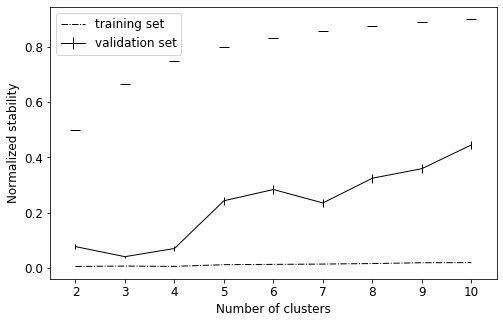

In [21]:
from reval.visualization import plot_metrics
plot_metrics(metric)

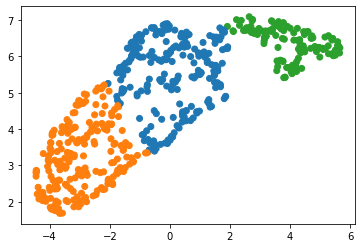

In [22]:
#umap plot train
import matplotlib.pyplot as plt
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

plt.scatter(X_tr_prepr[[0]], X_tr_prepr[[1]], color=[colors[lab] for lab in out.train_cllab])


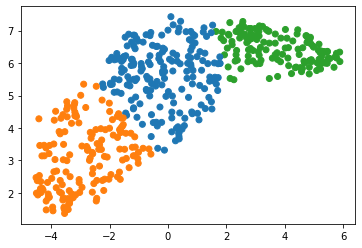

In [23]:
plt.scatter(X_ts_prepr[[0]], X_ts_prepr[[1]], color=[colors[lab] for lab in out.test_cllab])

In [24]:
#save for reval plot
for table in metric.keys():
    data = pd.DataFrame(columns=['k','value','CI'])
    for row in metric[table]:
        _dict_append = {'k':row,
                     'value':metric[table][row][1][0],
                     'CI':metric[table][row][1][1]}
        data= data.append(_dict_append,ignore_index=True)
        
    data.to_csv(os.path.join(results_path,'_'.join([table,'metric_for_plot_041022.csv'])))

In [25]:
results_path

'/Users/vmandelli/OneDrive - Fondazione Istituto Italiano Tecnologia/vineland_proj_edition/results'

In [26]:
#save umap values for future works!
X_tr_2save = X_tr.copy()
X_ts_2save = X_ts.copy()
X_tr_2save['tr_ts']='tr'
X_tr_2save['cluster_domain']=out.train_cllab
X_ts_2save['tr_ts']='ts'
X_ts_2save['cluster_domain']=out.test_cllab
UMAP_values_2save = X_tr_2save.append(X_ts_2save)
UMAP_values_2save.to_csv(os.path.join(results_path,"UMAP_values_P1_editioncorrected_041022.csv"))

In [27]:
#save results
TR_original['cluster_domain']=  out.train_cllab
TR_original["TR_TS"] = "tr"

TS_original['cluster_domain']=  out.test_cllab
TS_original["TR_TS"] = "ts"
dataset_trts_cl = TR_original.append(TS_original)
dataset_trts_cl.to_csv(os.path.join(results_path,"VABS_withcluster_edition_041022.csv"))

In [28]:
TR_original

,Unnamed: 0,ageyrs_round,interview_period,collection_id,interview_age,edition,original_communicationdomain_totalb,original_livingskillsdomain_totalb,original_socializationdomain_totalb,original_motorskillsdomain_totalb,...,sex,countna,format,TR_TS,communicationdomain_totalb,livingskillsdomain_totalb,socializationdomain_totalb,motorskillsdomain_totalb,composite_totalb,cluster_domain
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDARYH920PMG,1,5,P1,1865,63,2,79.0,100,77.0,94.0,...,M,0,survey,tr,83.114274,101.097414,80.081418,96.312881,87.483174,1
NDAREZ550UCM,2,3,P1,1,40,2,89.0,83,81.0,94.0,...,F,0,survey,tr,93.114274,84.097414,84.081418,96.312881,86.483174,1
NDARKL624BHL,3,5,P1,1,61,2,83.0,69,65.0,70.0,...,M,0,survey,tr,87.114274,70.097414,68.081418,72.312881,70.483174,0
NDARJA752ZZK,4,1,P1,2026,15,2,80.0,91,98.0,100.0,...,M,0,survey,tr,84.114274,92.097414,101.081418,102.312881,92.483174,1
NDAR_INVMZ8TWKBC,5,6,P1,2064,68,2,61.0,69,83.0,72.0,...,M,0,interview,tr,61.000000,69.000000,83.000000,72.000000,68.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NDAR_INVYH008FAE,599,6,P1,1600,70,2,104.0,97,108.0,88.0,...,M,0,interview,tr,104.000000,97.000000,108.000000,88.000000,99.000000,1
NDARZH868ZU9,600,2,P1,1946,18,2,87.0,75,82.0,102.0,...,M,0,interview,tr,87.000000,75.000000,82.000000,102.000000,84.000000,1
NDARWA696YWX,601,4,P1,14,50,2,93.0,89,75.0,111.0,...,M,0,survey,tr,97.114274,90.097414,78.081418,113.312881,92.483174,1
